<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [3]:
def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

In [4]:
def testing_envs(env_name, VISUALIZE, logging_interval = 10):
    logdir = ("./" + env_name + "_videos/")
    env = gym.make(env_name)
    if VISUALIZE:
        if not os.path.exists(logdir):
            os.mkdir(logdir)
            env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
    return env

def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [5]:
from gym import envs

VISUALIZE = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
#env_key = "InvertedPendulum-v2" #Unique identifier for custom envs (case sensitive)
env_key = "InvertedPendulum"

env_name = 'InvertedPendulum-v2'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'

env_ids = [spec.id for spec in envs.registry.all()]
#test_env_names = [env_name] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Testing on original and new envs
test_envs = [testing_envs(env_name, VISUALIZE, logging_interval) for env_name in test_env_names[1:-1]]

#Plotting Results and figures, save weights
script_dir = os.getcwd()
results_dir = os.path.join(script_dir, 'plotting_results/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.makedirs(baseline_dir)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

## Training loop

In [6]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

from ppo import *
ppo_baseline = PPO(num_inputs, num_outputs)
#model = ppo_baseline.model
#optimizer = ppo_baseline.optimizer

In [7]:
max_frames = 50000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20

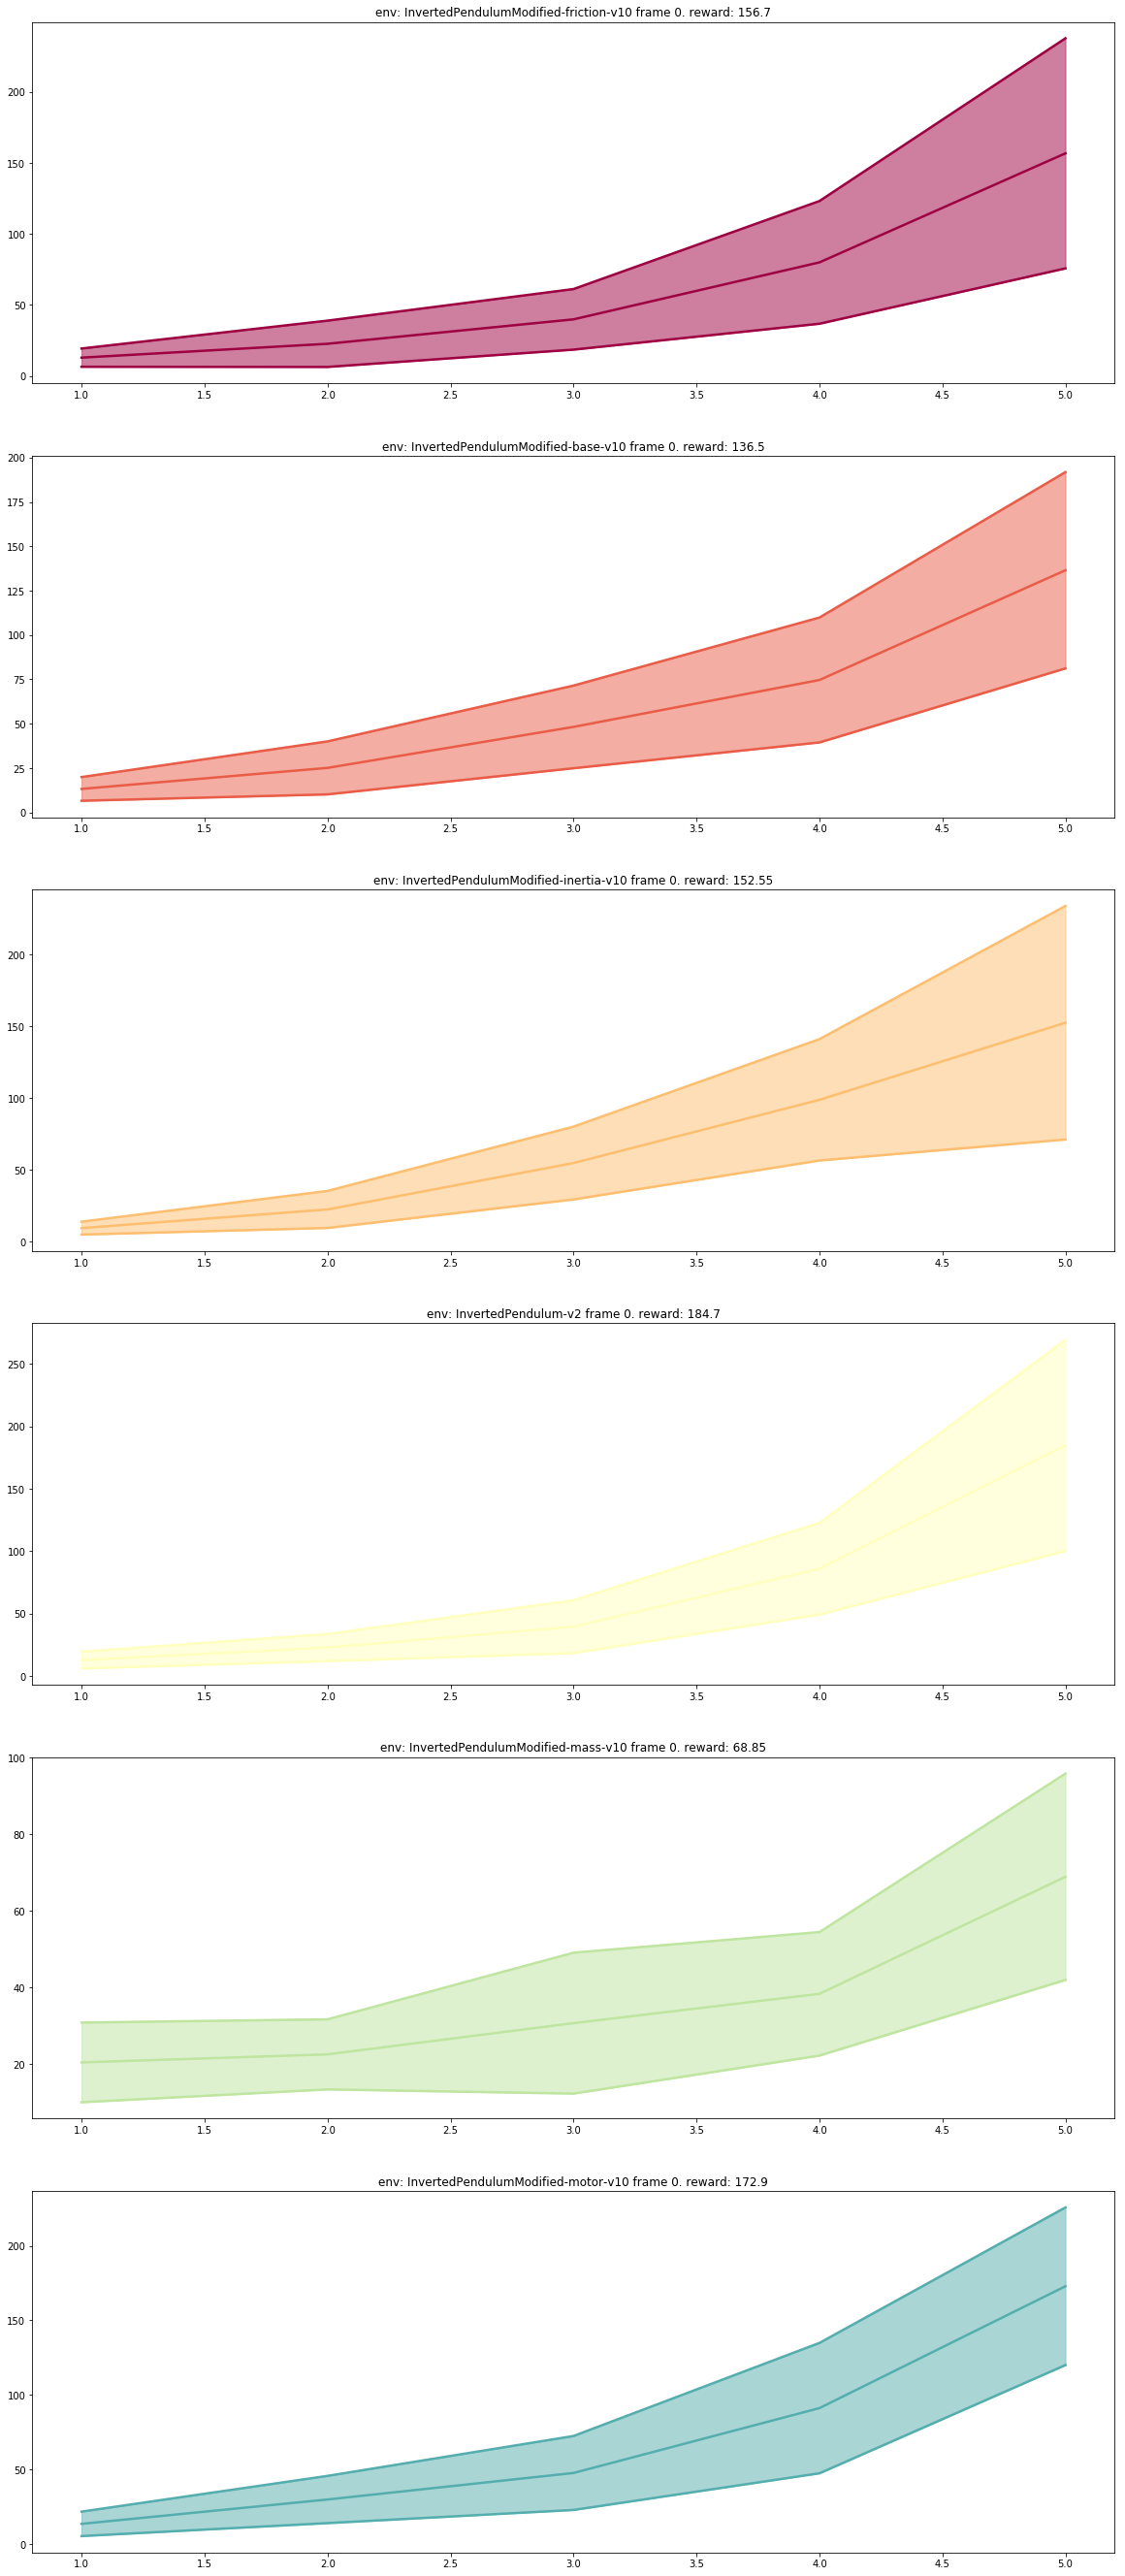

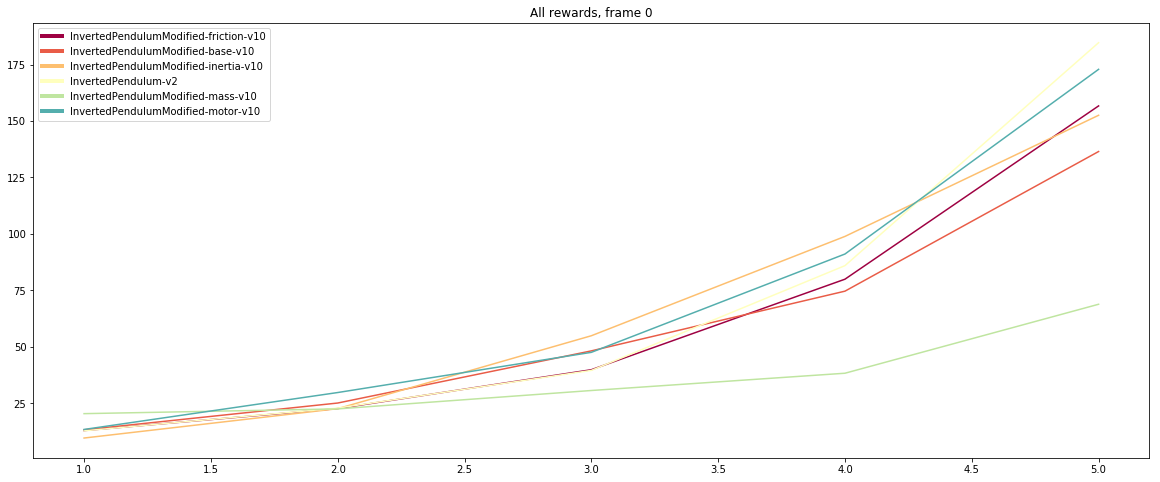

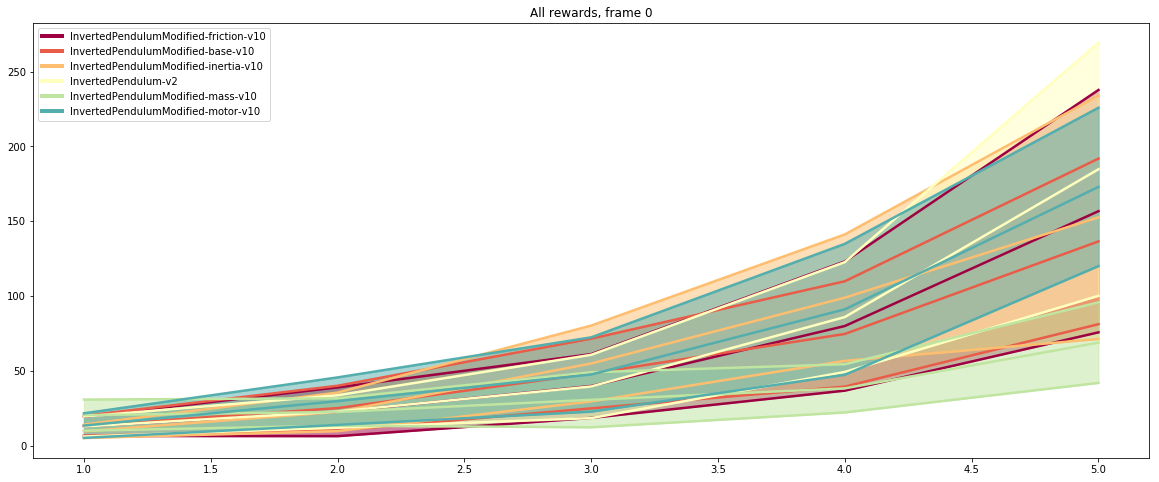

In [ ]:
state = envs.reset()
early_stop = False

while ppo_baseline.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = ppo_baseline.collect_data(envs)
    
    #compute gae
    returns = ppo_baseline.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    ppo_baseline.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []

    for env in test_envs:
        env_rewards = ([test_env(ppo_baseline.model, env) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)


    if avg_rew[0] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        plot(frame_idx, test_avg_rewards, test_stds, test_env_names, results_dir, save = 1)
        early_stop = True
    else:
        plot(frame_idx, test_avg_rewards, test_stds, test_env_names, results_dir, save = 0)

ppo_baseline.save_weights(baseline_dir + 'env_name')

In [11]:
ppo_baseline.frame_idx

57344